In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [253]:
trip= pd.read_csv('trip.csv')

In [254]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [255]:
trip.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [256]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 11 columns):
id                    669959 non-null int64
duration              669959 non-null int64
start_date            669959 non-null object
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null object
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
dtypes: int64(5), object(6)
memory usage: 56.2+ MB


In [257]:
trip['start_date']= pd.to_datetime(trip['start_date'],format='%m/%d/%Y %H:%M')

In [7]:
# trip.duration = trip.duration/60

In [8]:
# trip.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

In [258]:
trip['datetime']=trip['start_date'].dt.date
trip['day']=trip['start_date'].dt.dayofweek
trip['hour']=trip['start_date'].dt.hour
trip['month']=trip['start_date'].dt.month
trip['week']=trip['start_date'].dt.week

In [259]:
trip['day']= trip.day.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

In [260]:
trip.month = trip.month.map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})

In [263]:
cal = calendar()
holidays = cal.holidays(start = trip.datetime.min(),end=trip.datetime.max())

In [264]:
holidays

DatetimeIndex(['2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03'],
              dtype='datetime64[ns]', freq=None)

In [275]:
trip['holiday']= trip.datetime.apply(lambda x: x in(holidays))

In [276]:
trip.holiday.unique()

array([False,  True])

In [277]:
workingday = ['Monday','Tuesday','Wednesday','Thursday','Friday']

In [278]:
trip['workingday']=trip.day.isin(workingday)

In [279]:
trip.rename(columns = {'start_date':'date','start_station_name':'station_name','start_station_id':'station_id'},inplace=True)

In [280]:
trip = trip.drop(['id','end_date','end_station_name','end_station_id','bike_id'],axis=1)

In [281]:
for col in ['station_name','station_id','subscription_type','zip_code','datetime','day','hour','week','month','week','holiday','workingday']:
    trip[col]=trip[col].astype('category')

In [282]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 13 columns):
duration             669959 non-null int64
date                 669959 non-null datetime64[ns]
station_name         669959 non-null category
station_id           669959 non-null category
subscription_type    669959 non-null category
zip_code             663340 non-null category
datetime             669959 non-null category
day                  669959 non-null category
hour                 669959 non-null category
month                669959 non-null category
week                 669959 non-null category
holiday              669959 non-null category
workingday           669959 non-null category
dtypes: category(11), datetime64[ns](1), int64(1)
memory usage: 18.9 MB


In [283]:
trip.head()

,duration,date,station_name,station_id,subscription_type,zip_code,datetime,day,hour,month,week,holiday,workingday
0,63,2013-08-29 14:13:00,South Van Ness at Market,66,Subscriber,94127,2013-08-29,Thursday,14,August,35,False,True
1,70,2013-08-29 14:42:00,San Jose City Hall,10,Subscriber,95138,2013-08-29,Thursday,14,August,35,False,True
2,71,2013-08-29 10:16:00,Mountain View City Hall,27,Subscriber,97214,2013-08-29,Thursday,10,August,35,False,True
3,77,2013-08-29 11:29:00,San Jose City Hall,10,Subscriber,95060,2013-08-29,Thursday,11,August,35,False,True
4,83,2013-08-29 12:02:00,South Van Ness at Market,66,Subscriber,94103,2013-08-29,Thursday,12,August,35,False,True


In [ ]:
# trip EDA

In [200]:
total_count =pd.DataFrame(trip.groupby(['datetime','subscription_type']).size()).reset_index()

In [213]:
total_count.columns=['date','subscription_type','count']

In [214]:
total_count.head()

,date,subscription_type,count
count,2013-08-29,Customer,287
1,2013-08-29,Subscriber,461
2,2013-08-30,Customer,406
3,2013-08-30,Subscriber,308
4,2013-08-31,Customer,480


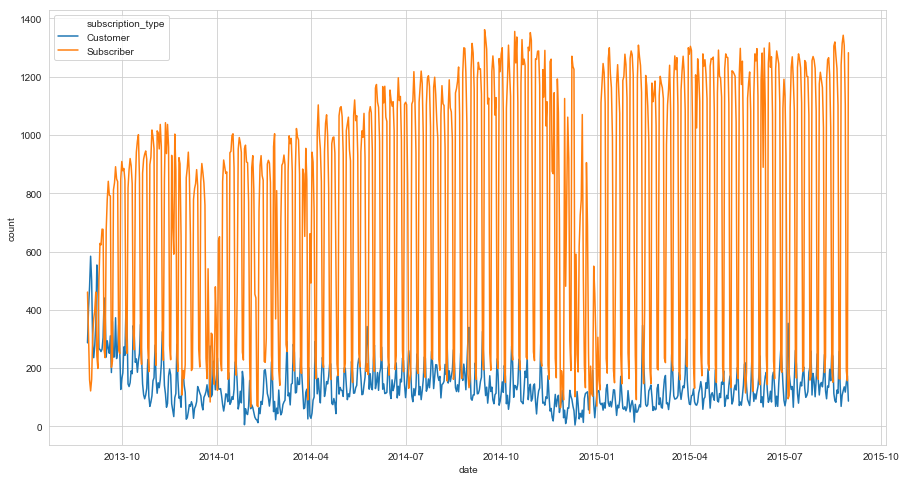

In [216]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date',y='count',hue ='subscription_type',data=total_count)

In [227]:
workingday = trip.groupby(['workingday','subscription_type']).size()
workingday = workingday.unstack('subscription_type')

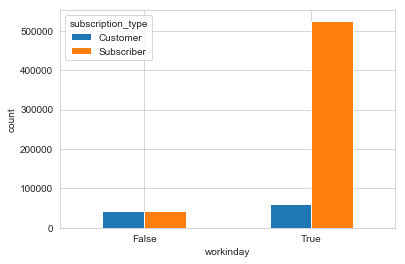

In [240]:
workingday.plot(kind='bar')
plt.xlabel('workinday')
plt.ylabel('count')
plt.xticks(rotation=360)
plt.show()

In [290]:
holiday = trip.groupby(['holiday','subscription_type']).size()
holiday = holiday.unstack('subscription_type')

In [291]:
holiday

subscription_type,Customer,Subscriber
holiday,,
False,99589,559531
True,3624,7215


In [ ]:
# total tripes per month

In [316]:
monthly_count = pd.DataFrame(trip.groupby('month').size()).reset_index()
monthly_count.columns = ['month','count']
monthly_count = monthly_count.sort_values(by="count",ascending=False)

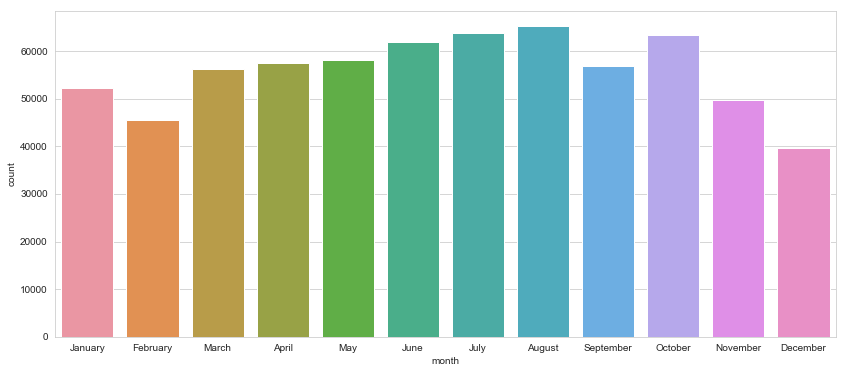

In [322]:
plt.figure(figsize=(14,6))
monthOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.barplot(data=monthly_count, x="month", y="count",order=monthOrder)

In [ ]:
# total trips per day

In [326]:
hourly_count = pd.DataFrame(trip.groupby(['hour','day']).size()).reset_index()

In [327]:
hourly_count.columns = ['hour','day','count']

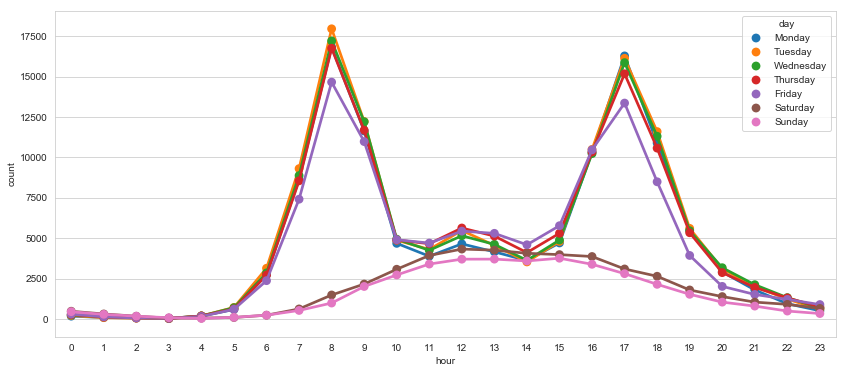

In [330]:
plt.figure(figsize=(14,6))
weekOrder =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.pointplot(x='hour',y='count',hue ='day',hue_order= weekOrder,data=hourly_count)

In [331]:
hourly = pd.DataFrame(trip.groupby(['hour','subscription_type']).size()).reset_index()
hourly.columns =['hour','suscription_type','count']

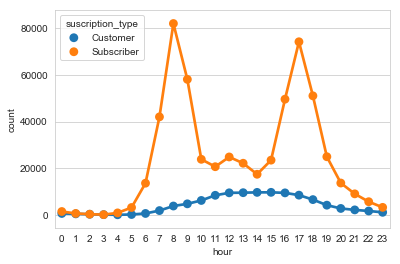

In [332]:
sns.pointplot(x='hour',y='count',hue ='suscription_type',data=hourly)

In [ ]:
# station file

In [49]:
station = pd.read_csv('station.csv')

In [50]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int64
name                 70 non-null object
lat                  70 non-null float64
long                 70 non-null float64
dock_count           70 non-null int64
city                 70 non-null object
installation_date    70 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 3.9+ KB


In [51]:
station.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [52]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [53]:
for col in ['name','city']:
    station[col]=station[col].astype('category')

In [54]:
station.installation_date = pd.to_datetime(station['installation_date'])
station.rename(columns = {'name':'station_name'},inplace=True)
station= station.drop(['id','lat','long'],axis=1)

In [55]:
station.head()

,station_name,dock_count,city,installation_date
0,San Jose Diridon Caltrain Station,27,San Jose,2013-08-06
1,San Jose Civic Center,15,San Jose,2013-08-05
2,Santa Clara at Almaden,11,San Jose,2013-08-06
3,Adobe on Almaden,19,San Jose,2013-08-05
4,San Pedro Square,15,San Jose,2013-08-07


In [138]:
df = trip.merge(station, how ='left',on='station_name')

In [139]:
df.columns

Index(['duration', 'date', 'station_name', 'station_id', 'subscription_type',
       'zip_code', 'datetime', 'day', 'hour', 'month', 'week', 'holiday',
       'workingday', 'dock_count', 'city', 'installation_date'],
      dtype='object')

In [140]:
df.head()

,duration,date,station_name,station_id,subscription_type,zip_code,datetime,day,hour,month,week,holiday,workingday,dock_count,city,installation_date
0,63,2013-08-29 14:13:00,South Van Ness at Market,66,Subscriber,94127,2013-08-29,Thursday,14,August,35,False,True,19.0,San Francisco,2013-08-23
1,70,2013-08-29 14:42:00,San Jose City Hall,10,Subscriber,95138,2013-08-29,Thursday,14,August,35,False,True,15.0,San Jose,2013-08-06
2,71,2013-08-29 10:16:00,Mountain View City Hall,27,Subscriber,97214,2013-08-29,Thursday,10,August,35,False,True,15.0,Mountain View,2013-08-16
3,77,2013-08-29 11:29:00,San Jose City Hall,10,Subscriber,95060,2013-08-29,Thursday,11,August,35,False,True,15.0,San Jose,2013-08-06
4,83,2013-08-29 12:02:00,South Van Ness at Market,66,Subscriber,94103,2013-08-29,Thursday,12,August,35,False,True,19.0,San Francisco,2013-08-23


In [333]:
weather = pd.read_csv('weather.csv')

In [334]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [336]:
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [149]:
weather['datetime'] = pd.to_datetime(weather.date)

In [150]:
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [151]:
zipcode_city = dict({94107:'San Francisco',94063:'Redwood City',94301:'Palo Alto',94041:'Mountain View',95113:'San Jose'})

In [155]:
weather['city'] = weather.zip_code.apply(lambda x: zipcode_city[x])
weather[['city','datetime']] = weather[['city','datetime']].astype('category')

In [153]:
weather.columns

Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code', 'datetime',
       'city'],
      dtype='object')

In [154]:
weather.dtypes

date                                      object
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

In [156]:
weather_df = weather[['datetime','mean_temperature_f','mean_humidity','mean_visibility_miles','mean_wind_speed_mph','zip_code','city']]

In [157]:
weather_df.dtypes

datetime                 category
mean_temperature_f        float64
mean_humidity             float64
mean_visibility_miles     float64
mean_wind_speed_mph       float64
zip_code                    int64
city                     category
dtype: object

In [163]:
df =df.merge(weather,how='left',on =['datetime','city'])

In [164]:
df.isnull().sum()

duration                               0
date_x                                 0
station_name                           0
station_id                             0
subscription_type                      0
zip_code_x                          6619
datetime                               0
day                                    0
hour                                   0
month                                  0
week                                   0
holiday                                0
workingday                             0
dock_count                         11342
city                               11342
installation_date                  11342
mean_temperature_f_x               11408
mean_humidity_x                    11695
mean_visibility_miles_x            11495
mean_wind_speed_mph_x              11356
zip_code_y                         11342
date_y                             11342
max_temperature_f                  11408
mean_temperature_f_y               11408
min_temperature_

In [165]:
df.head()

,duration,date_x,station_name,station_id,subscription_type,zip_code_x,datetime,day,hour,month,...,mean_visibility_miles_y,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph_y,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,63,2013-08-29 14:13:00,South Van Ness at Market,66,Subscriber,94127,2013-08-29,Thursday,14,August,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107.0
1,70,2013-08-29 14:42:00,San Jose City Hall,10,Subscriber,95138,2013-08-29,Thursday,14,August,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113.0
2,71,2013-08-29 10:16:00,Mountain View City Hall,27,Subscriber,97214,2013-08-29,Thursday,10,August,...,10.0,10.0,16.0,5.0,16.0,0,4.0,NaN,355.0,94041.0
3,77,2013-08-29 11:29:00,San Jose City Hall,10,Subscriber,95060,2013-08-29,Thursday,11,August,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113.0
4,83,2013-08-29 12:02:00,South Van Ness at Market,66,Subscriber,94103,2013-08-29,Thursday,12,August,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107.0


In [168]:
count = pd.DataFrame(df.groupby(['datetime','city']).size())

In [170]:
count.head(10)

0
datetime   city              
2013-08-29 Mountain View   12
           Palo Alto       23
           Redwood City     9
           San Francisco  642
           San Jose        62
2013-08-30 Mountain View   18
           Palo Alto       11
           Redwood City     9
           San Francisco  606
           San Jose        70